## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchaudio
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
from sklearn.model_selection import train_test_split
from torchsummary import summary
import glob
import tqdm
from dataset import SpectrogramDataset
import utils
from utils import plot_confusion_matrix

## CNN model

In [18]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, classes):
        super(CNNClassifier, self).__init__()
        
        self.classes = classes
        num_classes = len(classes)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(128 * 5 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        self.relu = nn.ReLU()
        
        self.criterion = nn.CrossEntropyLoss()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
        
        self.test_confusion_matrix = np.zeros((num_classes, num_classes))
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = self.relu(self.conv4(x))
        x = self.maxpool(x)
        #print(x.shape)
        x = x.view(-1, 128 * x.shape[2] * x.shape[3])
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('train_acc', accuracy, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('val_acc', accuracy)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('test_acc', accuracy)
        
        confusion_matrix = self.confusion_matrix(predicted, y)
        self.test_confusion_matrix += confusion_matrix.cpu().numpy()
        
    def on_test_epoch_end(self):
        plot_confusion_matrix(self.test_confusion_matrix, self.classes, filename='confusion_matrix.png')
        
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x = batch
        y_hat = self(x)
        
        _, predicted = torch.max(y_hat, 1)
        return predicted

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

## Import data and labels


In [3]:
NPDATAPATH = 'data/measurment-2/data.npy'
NPLABELPATH = 'data/measurment-2/labels.npy'
# Try to load the data from the numpy file
try:
    data_np = np.load(NPDATAPATH)
    data_size = (data_np.shape[2], data_np.shape[3])
    labels_np = np.load(NPLABELPATH)
    
    labels_np = labels_np.astype(int)
    data_np = data_np.astype(float)
    
    
    
except:
    # If the file doesn't exist, create it.
    DATAPATH = 'data/measurment-2/clips/wav/'
    LABELPATH = 'data/measurment-2/clips/txt/'

    data = glob.glob(DATAPATH + '*.wav')
    labels = glob.glob(LABELPATH + '*.txt')

    # Convert each wav file to a spectrogram and save it in a numpy array
    #data_np = np.empty((len(data)))
    #labels_np = np.empty((len(labels)))
    data_np = []
    labels_np = []
    # Use tqdm to show progress bar
    pbar = tqdm.tqdm(total=len(data))

    # Only test on 10 files for now
    #data = data[:100]
    i = 0
    for file, label in zip(data, labels):
        audio_file, rate_of_sample = torchaudio.load(file)
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=rate_of_sample, n_mels=128, n_fft=2048)(audio_file)
        spectrogram = torchaudio.transforms.AmplitudeToDB()(np.abs(spectrogram))
        data_np.append(spectrogram)
        labels_np.append(0) # TODO: Change this to the label
        i += 1
        """if data_np.size == 0:
            data_np[i] = spectrogram
            labels_np[i] = label
        else:
            data_np = np.concatenate((data_np, spectrogram), axis=0)
            labels_np = np.concatenate((labels_np, label), axis=0)"""
        pbar.update(1)
    pbar.close()
    # Convert list of numpy arrays to a single numpy array
    data_np = np.stack(data_np, dtype=np.float32, axis=0)
    labels_np = np.stack(labels_np, dtype=np.float32, axis=0)
    data_size = (data_np.shape[2], data_np.shape[3])
    print('Data shape:', data_np.shape)
    print('Labels shape:', labels_np.shape)
    
    # Data is now a numpy array of shape (num_files, 1, 128, 87)
    # Data should be of shape (num_files, 128, 87)
    
    data_np = np.squeeze(data_np, axis=1)
    print('Data shape:', data_np.shape)
    
    
    # Save the numpy array
    np.save('data/measurment-2/data.npy', data_np)
    np.save('data/measurment-2/labels.npy', labels_np)


100%|██████████| 3862/3862 [00:10<00:00, 370.67it/s]


Data shape: (3862, 1, 128, 94)
Labels shape: (3862,)
Data shape: (3862, 128, 94)


## Just for fun: spectrogram plot loop
Uncomment if you want to see the plot of the spectrograms in a loop.

In [4]:

#%matplotlib qt
#utils.loop_plot_audio_spectogram(data_np)
#%matplotlib inline

## Prepare Training, validation and test data

In [5]:
TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1

if TRAINING_RATIO + VALIDATION_RATIO + TEST_RATIO != 1:
    raise ValueError('Training, validation, and test ratios must sum to 1.')

train_size = int(TRAINING_RATIO * len(data_np))
val_size = int(VALIDATION_RATIO * len(data_np))
test_size = len(data_np) - train_size - val_size

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(data_np, labels_np, test_size=val_size, random_state=42)
train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(train_spectrograms, train_labels, test_size=test_size, random_state=42)

print('Training samples:', train_spectrograms.shape[0])
print('Validation samples:', val_spectrograms.shape[0])
print('Test samples:', test_spectrograms.shape[0])

Training samples: 3089
Validation samples: 386
Test samples: 387


## Define transforms

In [6]:
# Define data transforms for data augmentation
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add more transforms here
])

## Make datasets

In [7]:
BATCH_SIZE = 32
NUM_WORKERS = 4

# Create datasets and dataloaders
train_dataset = SpectrogramDataset(train_spectrograms, train_labels, transform=transform)
val_dataset = SpectrogramDataset(val_spectrograms, val_labels, transform=transforms.ToTensor())
test_dataset = SpectrogramDataset(test_spectrograms, test_labels, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## Define classes, and summary of the model

In [8]:
CLASSES = ['Background', 'Anomaly']

model = CNNClassifier(classes=CLASSES)
print("Data size: ", data_size)

summary(model, (1 , data_size[0], data_size[1]))

Data size:  (128, 94)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 128, 94]         160
├─ReLU: 1-2                              [-1, 16, 128, 94]         --
├─MaxPool2d: 1-3                         [-1, 16, 64, 47]          --
├─Conv2d: 1-4                            [-1, 32, 64, 47]          4,640
├─ReLU: 1-5                              [-1, 32, 64, 47]          --
├─MaxPool2d: 1-6                         [-1, 32, 32, 23]          --
├─Conv2d: 1-7                            [-1, 64, 32, 23]          18,496
├─ReLU: 1-8                              [-1, 64, 32, 23]          --
├─MaxPool2d: 1-9                         [-1, 64, 16, 11]          --
├─Conv2d: 1-10                           [-1, 128, 16, 11]         73,856
├─ReLU: 1-11                             [-1, 128, 16, 11]         --
├─MaxPool2d: 1-12                        [-1, 128, 8, 5]           --
├─Linear: 1-13                           [-1, 256] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 128, 94]         160
├─ReLU: 1-2                              [-1, 16, 128, 94]         --
├─MaxPool2d: 1-3                         [-1, 16, 64, 47]          --
├─Conv2d: 1-4                            [-1, 32, 64, 47]          4,640
├─ReLU: 1-5                              [-1, 32, 64, 47]          --
├─MaxPool2d: 1-6                         [-1, 32, 32, 23]          --
├─Conv2d: 1-7                            [-1, 64, 32, 23]          18,496
├─ReLU: 1-8                              [-1, 64, 32, 23]          --
├─MaxPool2d: 1-9                         [-1, 64, 16, 11]          --
├─Conv2d: 1-10                           [-1, 128, 16, 11]         73,856
├─ReLU: 1-11                             [-1, 128, 16, 11]         --
├─MaxPool2d: 1-12                        [-1, 128, 8, 5]           --
├─Linear: 1-13                           [-1, 256]                 1,310,

## Define trainer

In [9]:
MAX_EPOCHS = 30
VERSION = 'cnn_v2_epoch-30-v2'

accelerator = None
if torch.cuda.is_available():
    accelerator = 'gpu'
elif torch.backends.mps.is_available():
    accelerator = 'cpu'  # MPS is not implemented in PyTorch yet

tb_logger = loggers.TensorBoardLogger('.', version=VERSION)
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, save_last=True, filename='best-{epoch}-{val_acc:.2f}')

trainer = Trainer(accelerator=accelerator, max_epochs=MAX_EPOCHS, logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Start training

In [10]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                      | Params
---------------------------------------------------------------
0 | conv1            | Conv2d                    | 160   
1 | conv2            | Conv2d                    | 4.6 K 
2 | conv3            | Conv2d                    | 18.5 K
3 | conv4            | Conv2d                    | 73.9 K
4 | maxpool          | MaxPool2d                 | 0     
5 | fc1              | Linear                    | 1.3 M 
6 | fc2              | Linear                    | 514   
7 | relu             | ReLU                      | 0     
8 | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [19]:
# Load previously trained model
CHECKPOINT_PATH = f'lightning_logs/{VERSION}/checkpoints/best-epoch=0-val_acc=1.00.ckpt'

model = CNNClassifier.load_from_checkpoint(CHECKPOINT_PATH, classes=CLASSES)
print(f'Model size: {os.path.getsize(CHECKPOINT_PATH) / 1e6} MB')

Model size: 16.919634 MB


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

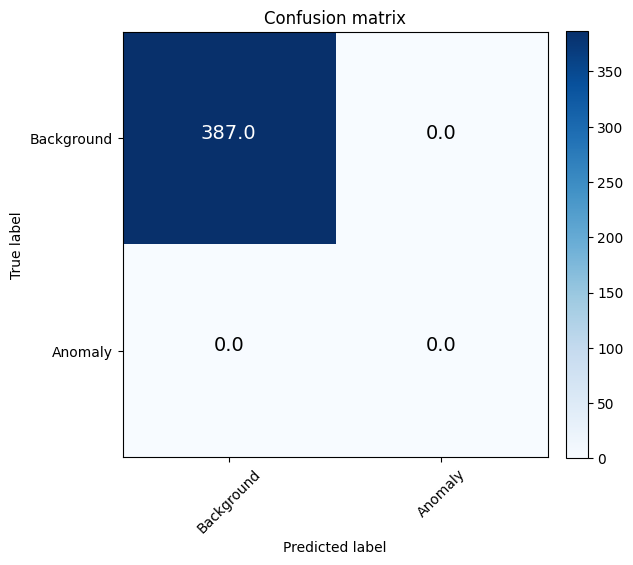

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss                   0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0, 'test_acc': 1.0}]

In [20]:
trainer.test(model, test_loader) # This not the challenge, test set

In [ ]:
spectrograms_to_predict = np.load('data/test.npy')

print('Test spectrogram to predict shape:', spectrograms_to_predict.shape)
print('Test spectrogram to predict dtype:', spectrograms_to_predict.dtype)

In [ ]:
test_to_predict_dataset = SpectrogramDataset(spectrograms_to_predict, transform=transforms.ToTensor())
test_to_predict_loader = DataLoader(test_to_predict_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
predictions = trainer.predict(model, test_to_predict_loader)
predictions = np.concatenate(predictions).astype(int)

In [ ]:
np.savetxt('predictions.txt', predictions, delimiter='\n', fmt='%d')